In [78]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate, correlation_matrix, plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

# Simulation without correlations

In [79]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic    

In [80]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1                                   # simulation output: Total Cost


In [81]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1


,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,11705.863,20.014,11.430,65354.183,234275.295,0.279
1,10960.532,20.321,15.228,22934.973,222725.916,0.103
2,13213.981,18.823,13.221,34376.413,248722.850,0.138
3,12211.973,20.878,13.452,54060.963,254967.044,0.212
4,9544.500,20.353,11.740,53572.205,194257.554,0.276
...,...,...,...,...,...,...
9995,12207.060,18.996,12.792,39112.957,231888.346,0.169
9996,12317.974,18.965,13.227,33720.510,233605.698,0.144
9997,8657.257,20.508,13.652,33374.299,177539.175,0.188
9998,11756.937,20.254,12.279,58484.629,238120.617,0.246


In [82]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()

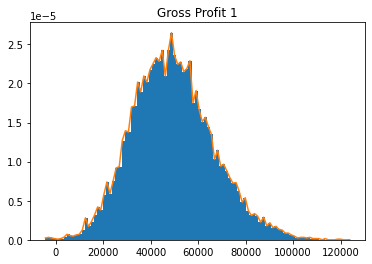

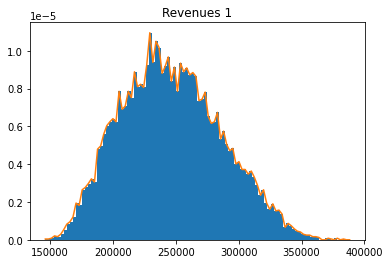

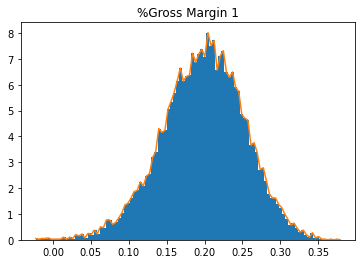

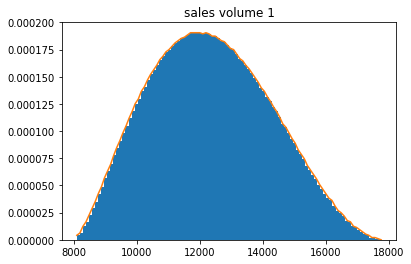

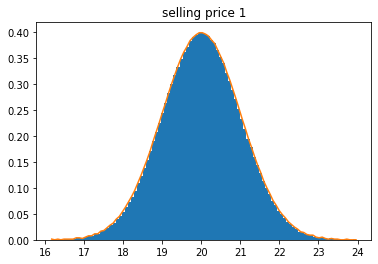

In [83]:
# results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")


In [84]:
# distribution properties of the inputs: moments
def input_moments(v, p, m):
    # simulation inputs: moments
    print("sales volume:")
    v1.describe()
    print("selling price:")
    p1.describe()
    print("raw material unit cost:")
    m1.describe()

In [85]:
# simulation output: moments
def output_moments(GP, R, GM, C):
    print("Gross Profit:")
    GP1.describe()
    print("Revenues:")
    R1.describe()
    print("Gross Margin:")
    GM1.describe()
    print("Total Cost:")
    C1.describe()

In [86]:
# get the simulation results:
inmom1 = input_moments(v1, p1, m1)
inmom1


sales volume:
MCERP Uncertain Value:
 > Mean...................  12333.336414538599
 > Variance...............  3507973.0842672302
 > Skewness Coefficient...  0.17798996735649442
 > Kurtosis Coefficient...  2.3756579676950076

selling price:
MCERP Uncertain Value:
 > Mean...................  20.00001675799338
 > Variance...............  0.9999391019211078
 > Skewness Coefficient...  0.0005705701597839986
 > Kurtosis Coefficient...  2.9975764167414

raw material unit cost:
MCERP Uncertain Value:
 > Mean...................  13.00002866705554
 > Variance...............  0.490091977744927
 > Skewness Coefficient...  0.002084963165298609
 > Kurtosis Coefficient...  3.0045228463310005



In [87]:
# get the simulation results:
outmom1 = output_moments(GP1, R1, GM1, C1)
outmom1

Gross Profit:
MCERP Uncertain Value:
 > Mean...................  49313.42579807797
 > Variance...............  288792214.46046853
 > Skewness Coefficient...  0.31652654646274425
 > Kurtosis Coefficient...  3.2021111117264343

Revenues:
MCERP Uncertain Value:
 > Mean...................  246655.04468825535
 > Variance...............  1554182026.4967496
 > Skewness Coefficient...  0.24750771745932076
 > Kurtosis Coefficient...  2.564359876699441

Gross Margin:
MCERP Uncertain Value:
 > Mean...................  0.19795929509942845
 > Variance...............  0.002907817834400688
 > Skewness Coefficient... -0.2367472370842768
 > Kurtosis Coefficient...  3.1760322615895062

Total Cost:
MCERP Uncertain Value:
 > Mean...................  197341.6188901774
 > Variance...............  976971605.293783
 > Skewness Coefficient...  0.2198617781577979
 > Kurtosis Coefficient...  2.4907153956690324



In [88]:
# get the correlation matrix BEFORE recalibrating
c1 = correlation_matrix([v1, p1, m1])
c1

array([[ 1.   , -0.006,  0.006],
       [-0.006,  1.   , -0.014],
       [ 0.006, -0.014,  1.   ]])

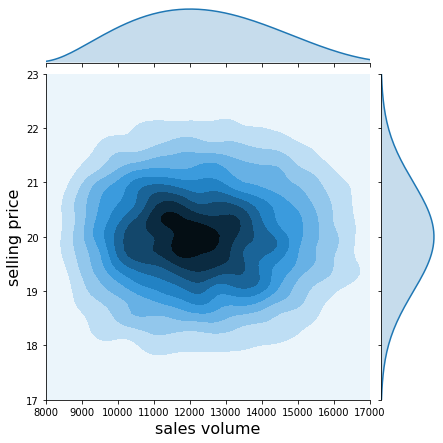

In [89]:
h = sns.jointplot(rv1, rp1, kind='kde', xlim=(8000, 17000), ylim=(17, 23), stat_func=None);
h.set_axis_labels('sales volume', 'selling price', fontsize=16);

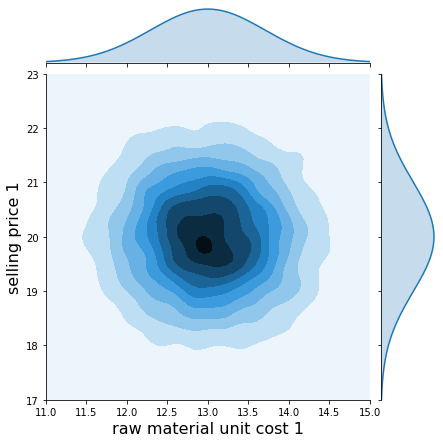

In [90]:
h = sns.jointplot(rm1, rp1, kind='kde', xlim=(11, 15), ylim=(17, 23), stat_func=None);
h.set_axis_labels('raw material unit cost 1', 'selling price 1', fontsize=16);

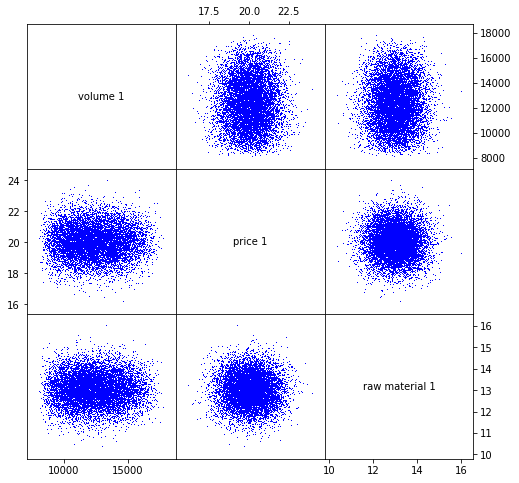

In [91]:
# plot correlations BEFORE recalibrating
corrplot0 = plotcorr([v1, p1, m1], labels=["volume 1", "price 1", "raw material 1"])

In [92]:
mean1 = GP1.mean
std1 = GP1.std
skew1 = GP1.skew
kurt1 = GP1.kurt
moments1 = [mean1, std1, skew1, kurt1]

# Impose different correlations

In [93]:
# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

In [94]:
v2 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p2 = N(ms, ss)                                  # selling price, normally distributed
m2 = N(mm, sm)                                  # material unit cost, normally distributed 
o2 = o                                          # other unit cost, deterministic    

In [95]:
# impose the targeted correlation matrix on the 3 input variables
correlate([v2, p2, m2], c_target)


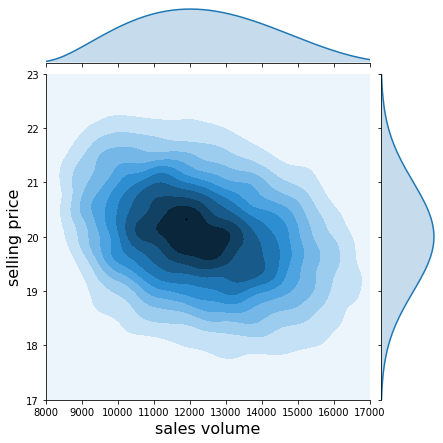

In [96]:
h = sns.jointplot(v2._mcpts, p2._mcpts, kind='kde', xlim=(8000, 17000), ylim=(17, 23), stat_func=None);
h.set_axis_labels('sales volume', 'selling price', fontsize=16);

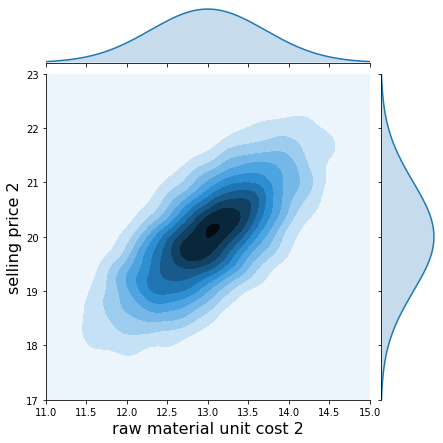

In [97]:
h = sns.jointplot(rm2, rp2, kind='kde', xlim=(11, 15), ylim=(17, 23), stat_func=None);
h.set_axis_labels('raw material unit cost 2', 'selling price 2', fontsize=16);

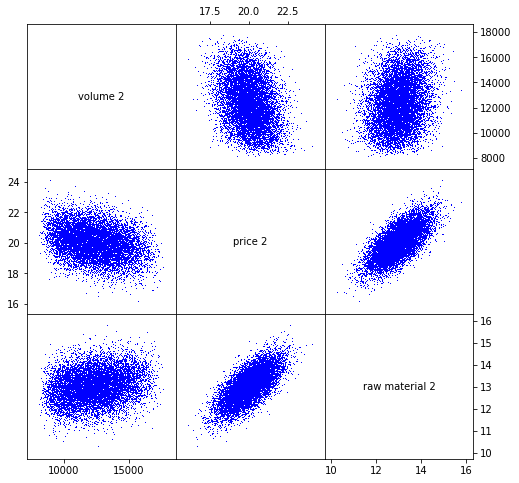

In [98]:
# plot the new correlation matrix of the input variables
corrplot2 = plotcorr([v2, p2, m2], labels=["volume 2", "price 2", "raw material 2"])

In [99]:
# check the new correlation matrix for the 3 input variables
c2 = correlation_matrix([v2, p2, m2])
c2

array([[ 1.   , -0.297,  0.2  ],
       [-0.297,  1.   ,  0.7  ],
       [ 0.2  ,  0.7  ,  1.   ]])

In [100]:
# deviations from targeted correlations?
c2 - c_target

array([[ 0.   ,  0.003,  0.   ],
       [ 0.003,  0.   , -0.   ],
       [ 0.   , -0.   , -0.   ]])

In [101]:
# induced changes vs original correlations
c2 - c1

array([[ 0.   , -0.291,  0.194],
       [-0.291,  0.   ,  0.714],
       [ 0.194,  0.714, -0.   ]])

In [102]:
# output variables:
# we rename the output variables to use consistent variable names in simu1 and simu2
GP2 = v2 * (p2 - m2 - o2)                       # simulation output: Gross Profit
R2 = v2 * p2                                    # simulation output: Revenues
GM2 = GP2 / R2                                  # simulation output: Gross Margin
C2 = R2 - GP2                                   # simulation output: Total Cost

In [103]:
# assign the 6x 10,000 variates to 6 variables so we can process their arrays later
rv2 = v2._mcpts
rp2 = p2._mcpts
rm2 = m2._mcpts
rGP2 = GP2._mcpts
rR2 = R2._mcpts
rGM2 = GM2._mcpts

# combine the 6 arrays in a 2-dimensional array
rand2 = np.vstack((rv2, rp2, rm2, rGP2, rR2, rGM2))

# copy the array to a dataframe for a more transparent layout
df2 = pd.DataFrame(data=rand2).T 
df2.rename(columns={ 
    0:"volume 2", 1:"price 2", 2:"material 2", 3:"Gross Profit 2", 4:"Revenues 2", 5:"Gross Margin 2"}, 
    inplace=True)
df2

,volume 2,price 2,material 2,Gross Profit 2,Revenues 2,Gross Margin 2
0,12436.714,19.160,11.868,53378.508,238293.166,0.224
1,9845.194,19.300,12.021,42125.967,190011.570,0.222
2,11543.997,19.722,12.813,45124.300,227672.903,0.198
3,12003.660,19.076,12.249,45937.776,228977.637,0.201
4,12600.664,20.957,13.527,55820.435,264073.296,0.211
...,...,...,...,...,...,...
9995,14768.110,18.604,13.083,37241.146,274749.672,0.136
9996,10407.912,20.508,12.897,47990.574,213442.675,0.225
9997,14664.969,18.309,12.105,46985.878,268506.604,0.175
9998,13533.773,19.721,13.091,49126.201,266904.388,0.184


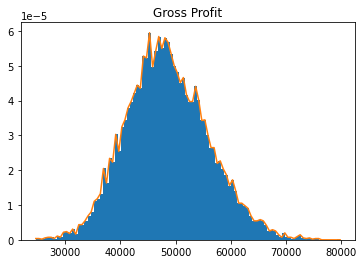

In [104]:
# results: draw histograms
plot_hist(rGP2, "Gross Profit")


In [105]:
# compare the main moments of the Gross Profit variable between the 2 simulation models:
moments_names = ["mean", "std", "skew", "kurt"]
moments2 = [GP2.mean, GP2.std, GP2.skew, GP2.kurt]

df = pd.DataFrame([moments1, moments2], columns=moments_names).T
df.rename(columns={0:"before", 1:"after"}, inplace=True)
df["variance"] = df["after"] - df["before"] 
df["%var"] = df["variance"] / df["before"] 
print("Moments of Gross Profit target variable: before vs after recalibrating correlations:")
df

Moments of Gross Profit target variable: before vs after recalibrating correlations:


,before,after,variance,%var
mean,49313.426,48513.985,-799.441,-0.016
std,16993.888,7357.785,-9636.103,-0.567
skew,0.317,0.242,-0.075,-0.236
kurt,3.202,3.080,-0.122,-0.038


In [106]:
    # quantiles of Gross Profit:
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    xq = np.quantile(rGP2, q)
    
    qstr = [str(f'{v:.3f}') for v in q]
    dict_quantiles = dict(zip(qstr, xq))
    print("\nquantiles:")
    _ = [print(q,":",f'{xq:,.0f}') for q,xq in dict_quantiles.items()]


quantiles:
0.001 : 27,302
0.010 : 32,606
0.050 : 37,078
0.100 : 39,312
0.150 : 40,977
0.200 : 42,294
0.250 : 43,439
0.300 : 44,486
0.350 : 45,388
0.400 : 46,346
0.450 : 47,229
0.500 : 48,111
0.550 : 49,004
0.600 : 49,957
0.650 : 51,023
0.700 : 52,149
0.750 : 53,415
0.800 : 54,632
0.850 : 56,152
0.900 : 58,232
0.990 : 66,701
0.999 : 73,486
